***UIT_CS115*** -
***FINAL PROJECT***

*GROUP 12 - CS115.P11*

_**TOPIC** : POLICY GRADIENT FOR REINFORCEMENT LEARNING_

***Insights:***
  
  Our code choose to implement A2C (Advantage Actor-Critic) algorithm (this can be out-performed by the other algorithms, which also means this algorithm works not so good) to solve this OpenAI CartPole-v1 game.

***Definition of Actor-Critc:***

The Actor-Critic algorithm is a type of **Reinforcement Learning** algorithm that combines aspects of both Policy-based methods (Actor) and Value-based methods (Critic). This hybrid approach is designed to address the limitations of each method when used individually.

In the actor-critic framework, an agent (the "actor") learns a policy to make decisions, and a value function (the "Critic") evaluates the actions taken by the Actor.

Simultaneously, the critic evaluates these actions by estimating their value or quality. This dual role allows the method to strike a balance between exploration and exploitation, leveraging the strengths of both policy and value functions.

***Advantage Actor Critic (A2C):***

We can stabilize learning further by using the Advantage function as Critic instead of the Action value function.

The idea is that the Advantage function calculates how better taking that action at a state is compared to the average value of the state.

***Include The Essential Library***

In [ ]:
!pip install gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.7 MB/s eta 0:00:00


In [2]:
import argparse
import gymnasium as gym
import numpy as np
from itertools import count
from collections import namedtuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import os


***Make CartPole-v1 Environment using OpenAI Gym***

In [3]:
# Define a named tuple to store saved actions
SavedAction = namedtuple('SavedAction', ['log_prob', 'value', 'state', 'action'])

# Create the CartPole environment with human render mode
env = gym.make('CartPole-v1', render_mode= None)

# Reset the environment to get the initial state
env.reset()


(array([-0.01345971, -0.03485594,  0.04820444,  0.00184891], dtype=float32),
 {})

***Implement Model Using Actor-Critic Method***

We think our model is Overfit to the Training data; however, it turns out to be advanced when we try to implements techniques such as Parallel Environments, Gradient Clipping and Entropy Loss. We tried hard and comprehended those techniques but the reason why it is so hard comes to the shortage ability of coding and comprehension of library such as PyTorch, Gymnasium or Stable Baselines3

In [ ]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        torch.nn.init.kaiming_uniform_(self.affine1.weight, a=0, mode='fan_in', nonlinearity='relu', generator=None)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

    def predict(self, observation, deterministic=True):
        """Given an observation, return the predicted action"""
        if observation.ndimension() == 1:
            observation = observation.unsqueeze(0)  # Add batch dimension if needed

        with torch.no_grad():
            action_probs, _ = self(observation)  # Get action probabilities and state value

        if deterministic:
            action = torch.argmax(action_probs, dim=-1).item()  # Use the action with the highest probability
        else:
            action = torch.multinomial(action_probs, num_samples=1).item()  # Sample a random action

        return action


***Select Action Function***

In [6]:
def select_action(state):
    """Given a state, return the action to take"""
    # Convert the state from a numpy array to a PyTorch tensor and add a batch dimension
    state = torch.from_numpy(state).float().unsqueeze(0)

    # Pass the state through the model to get action probabilities and state value
    probs, state_value = model(state)

    # Create a categorical distribution based on the action probabilities
    m = Categorical(probs)

    # Sample an action from the distribution
    action = m.sample()

    # Save the log probability of the action, the state value, the state, and the action
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value, state, action.item()))

    # Return the sampled action as an integer
    return action.item()


***Finish Episode***

In [ ]:
def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + 0.99 * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value,_,_), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


***Plotting Rewards***

In [8]:
def plot_rewards(episode_rewards, average_rewards):
    # Plotting the episode rewards
    plt.figure(figsize=(12, 6))

    # Generate episode numbers for the x-axis
    episodes = range(1, len(episode_rewards) + 1)

    # Plot average reward over episodes
    plt.plot(episodes, average_rewards, label='Average Reward', color='orange')  # Plot average rewards against episode numbers
    plt.xlabel('Episode')  # Set x-axis label
    plt.ylabel('Average Reward')  # Set y-axis label
    plt.title('Average Training Reward Over Episodes')  # Set plot title
    plt.legend()  # Add legend to the plot

    # Get the current working directory (folder where the script is running)
    current_directory = os.getcwd()
    # Define the file path where the plot will be saved
    file_path = os.path.join(current_directory, 'training_rewards_plot.png')

    # Save the plot as a PNG file in the current directory
    plt.tight_layout()
    plt.savefig(file_path)  # Save plot to current directory
    print(f"Plot saved at: {file_path}")


***Model Saving Function***

In [9]:
def save_model(model, filename="model.pth"):
    torch.save(model.state_dict(), filename) # Save the model state dictionary to the specified file


***Method To Evaluate Our Custom Actor-Critic Model***

In [25]:
from typing import Optional, Callable, Any, Union

def evaluate_my_model(
    model: "Policy",  # Type hint for your model
    env: gym.Env,
    n_eval_episodes: int = 10,
    deterministic: bool = False,
    render: bool = False,
    callback: Optional[Callable[[dict[str, Any], dict[str, Any]], None]] = None,
    reward_threshold: Optional[float] = None,
    return_episode_rewards: bool = False,
) -> Union[tuple[float, float], tuple[list[float], list[int]]]:
    """
    Runs policy for `n_eval_episodes` episodes and returns the mean reward and standard deviation.
    Optionally, you can render the environment, use callbacks, and return detailed rewards and episode lengths.
    """

    # Store rewards and lengths for each episode
    episode_rewards = []
    episode_lengths = []

    # Reset environment and initialize variables
    obs = env.reset()
    episode_reward = 0
    episode_length = 0
    done = False

    # Run evaluation for `n_eval_episodes`
    for episode in range(n_eval_episodes):
        episode_reward = 0
        episode_length = 0
        done = False
        while(1):
            # Ensure the observation is in the correct shape for the model
            if isinstance(obs, tuple):  # Some environments may return a tuple of observation + info
                obs = obs[0]
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

            # Get action from the model (use the model directly which calls `forward`)
            action = model.predict(obs_tensor, deterministic)

            # Step the environment with the action
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

            if done:  # If episode is done
                break  # Exit the loop


        episode_rewards.append(episode_reward)  # Store the total reward for this episode
        episode_lengths.append(episode_length)  # Store the length of this episode

    # Calculate mean and std of rewards across all episodes
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    if reward_threshold is not None:
        assert mean_reward > reward_threshold, f"Mean reward below threshold: {mean_reward:.2f} < {reward_threshold:.2f}"

    # Return either the mean reward or detailed episode data
    if return_episode_rewards:
        return episode_rewards, episode_lengths

    return mean_reward, std_reward


***Train Policy Model***

In [17]:
# Instantiate the Policy model
model = Policy()

# Create the Adam optimizer with the model parameters, learning rate of 0.03, and weight decay of 0.01
optimizer = optim.Adam(model.parameters(), lr=3e-2, weight_decay=0.01)

# Get the smallest positive number such that 1.0 + eps != 1.0 for float32
eps = np.finfo(np.float32).eps.item()


<ipython-input-19-9dba530ae68b>:27: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode 10	Reward: 10.00	Average reward: 0.98
Episode 20	Reward: 9.00	Average reward: 0.49
Episode 30	Reward: 10.00	Average reward: 0.32
Episode 40	Reward: 10.00	Average reward: 0.24
Episode 50	Reward: 9.00	Average reward: 0.19
Episode 60	Reward: 8.00	Average reward: 0.16
Episode 70	Reward: 9.00	Average reward: 0.14
Episode 80	Reward: 9.00	Average reward: 0.12
Episode 90	Reward: 10.00	Average reward: 0.11
Episode 100	Reward: 10.00	Average reward: 0.09
Episode 110	Reward: 8.00	Average reward: 0.09
Episode 120	Reward: 8.00	Average reward: 0.08
Episode 130	Reward: 12.00	Average reward: 0.07
Episode 140	Reward: 10.00	Average reward: 0.09
Episode 150	Reward: 9.00	Average reward: 0.08
Episode 160	Reward: 10.00	Average reward: 0.07
Episode 170	Reward: 22.00	Average reward: 0.08
Episode 180	Reward: 15.00	Average reward: 0.08
Episode 190	Reward: 28.00	Average reward: 0.08
Episode 200	Reward: 21.00	Average reward: 0.11
Episode 210	Reward: 61.00	Average reward: 0.17
Episode 220	Reward: 132.00	Ave

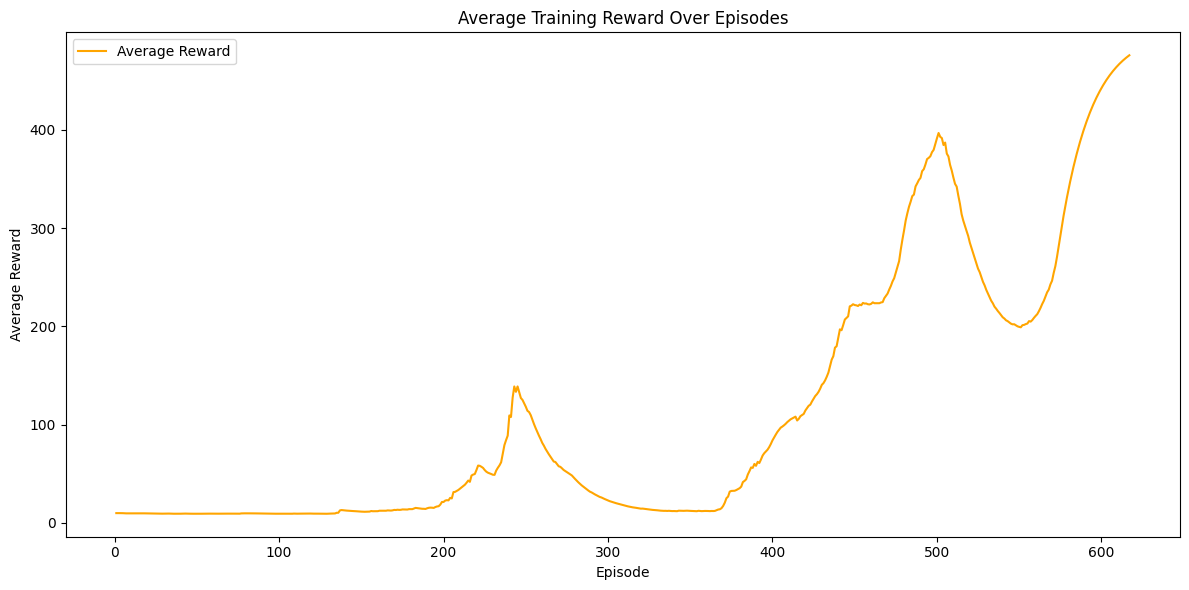

In [21]:
def main():
    running_reward = 10  # Initialize running reward
    episode_rewards = []  # Initialize list to store episode rewards
    average_rewards = []  # Initialize list to store average rewards
    done = False
    t = 0

    for i_episode in count(1):  # Infinite loop to run episodes

        state, _ = env.reset()  # Reset environment and get initial state
        state = np.array(state)  # Convert state to numpy array

        ep_reward = 0  # Initialize episode reward

        while(1):  # Loop for each time step in the episode
            action = select_action(state)  # Select action based on current state
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            # env.render()  # Render the environment
            model.rewards.append(reward)  # Store reward
            ep_reward += reward  # Accumulate episode reward
            if done:  # If episode is done
                break  # Exit the loop
            t+=1

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward  # Update running reward

        average_rewards.append(running_reward)  # Append running reward to list
        episode_rewards.append(ep_reward)  # Append episode reward to list

        finish_episode()  # Perform end of episode tasks

        log_interval = 10  # Set log interval
        if i_episode % log_interval == 0:  # If current episode is at log interval
            print(f'Episode {i_episode}\tReward: {ep_reward:.2f}\tAverage reward: {running_reward/i_episode:.2f}')  # Print episode and reward info

        if running_reward > env.spec.reward_threshold:  # If running reward exceeds threshold
            print(f"Solved! Running reward is now {running_reward} and the last episode runs to {t} time steps!")  # Print solved message
            break
        t = 0


    save_model(model, filename="trained_model.pth") # Save the trained model
    # Plot the rewards over time after training is done
    plot_rewards(episode_rewards, average_rewards) # Plot the rewards over time

if __name__ == '__main__':
    main()  # Run the main function


***Evaluate Our Model***

In [26]:
mean_reward, std_reward = evaluate_my_model(model, env, n_eval_episodes=10,deterministic=True) # Evaluate the model for 10 episodes

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}") # Print the mean and standard deviation of the rewards


mean_reward:50.90 +/- 149.70


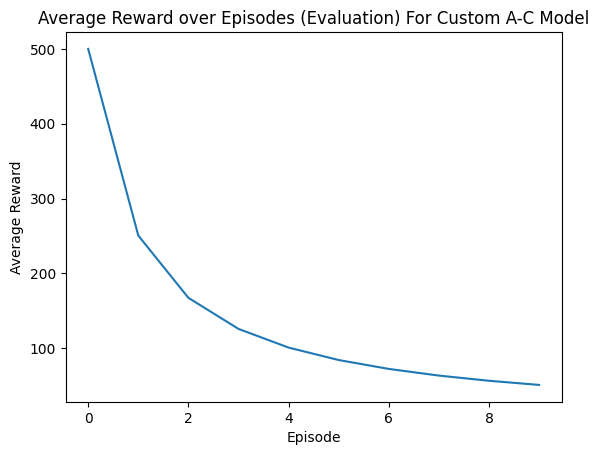

In [ ]:
# Evaluate the policy and store episode rewards
episode_rewards, episode_lengths = evaluate_my_model(model, env, n_eval_episodes=10,deterministic=True, return_episode_rewards=True)

# Calculate average reward over episodes
average_rewards = np.cumsum(episode_rewards) / np.arange(1, len(episode_rewards) + 1)

# Plot average reward over episodes
plt.plot(average_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward over Episodes (Evaluation) For Custom A-C Model")
plt.show()


# ***PPO Algorithm From Stable Baselines3 Library***

# Proximal Policy Optimization (PPO) for CartPole-v1

***Proximal Policy Optimization (PPO)*** is a reinforcement learning algorithm known for:
- Stability: Clipped updates prevent drastic policy changes.
- Simplicity: Easier to tune than other advanced algorithms.
- Efficiency: Works well in both discrete and continuous environments.

In this example, we use PPO with the `CartPole-v1` environment, where the goal is to balance a pole on a moving cart.


In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"  # Install the latest stable-baselines3 version


In [29]:
from stable_baselines3 import PPO # Import the PPO model
from stable_baselines3.ppo.policies import MlpPolicy # Import the policy module
from stable_baselines3.common.evaluation import evaluate_policy # Import the evaluation module


In [30]:
model_PPO = PPO(MlpPolicy, env, verbose=0) # Instantiate the PPO model with the MlpPolicy and the CartPole environment
model_PPO.learn(total_timesteps=100000) # Train the model for 100,000 time steps


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [31]:
mean_reward, std_reward = evaluate_policy(model_PPO, env, n_eval_episodes=10) # Evaluate the model for 200 episodes

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}") # Print the mean and standard deviation of the rewards


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:500.00 +/- 0.00


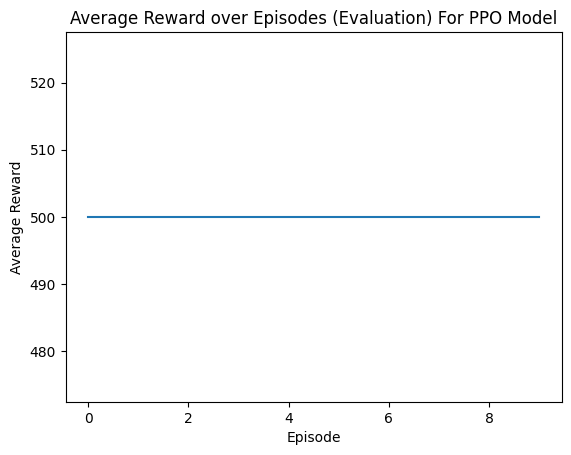

In [ ]:
# Evaluate the policy and store episode rewards
episode_rewards, episode_lengths = evaluate_policy(model_PPO, env, n_eval_episodes=10, return_episode_rewards=True)

# Calculate average reward over episodes
average_rewards = np.cumsum(episode_rewards) / np.arange(1, len(episode_rewards) + 1)

# Plot average reward over episodes
plt.plot(average_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward over Episodes (Evaluation) For PPO Model")
plt.show()


# ***DQN Algorithm From Stable Baselines3 Library***

# DQN (Deep Q-Network) Overview  
DQN is a **value-based** algorithm in Reinforcement Learning.

## **Nature of DQN:**

- **Value-based:** It focuses on approximating the Q(s, a) function, which represents the expected cumulative reward when taking action `a` in state `s` and following the optimal policy afterward.
- Actions are selected based on the Q-function:
  - `a = argmax_a Q(s, a)`
  - This means DQN always chooses the action `a` that maximizes the Q-value.

## **Compared to Policy-based Algorithms:**

- DQN does not learn a policy (mapping from states to actions) directly, as policy-based methods like PPO or REINFORCE do.
- Instead, it indirectly derives the policy through the Q(s, a) values.

## **In CartPole:**

DQN struggles because:

- The continuous state space makes it hard to approximate Q(s, a) effectively.
- It lacks the responsiveness required for environments demanding quick and precise policy decisions, like CartPole.


In [ ]:
from stable_baselines3 import DQN # Import the DQN model


In [34]:
model_DQN = DQN("MlpPolicy", env, verbose=0)
model_DQN.learn(total_timesteps=100000)


In [35]:
mean_reward, std_reward = evaluate_policy(model_DQN, env, n_eval_episodes=10) # Evaluate the model for 200 episodes
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}") # Print the mean and standard deviation of the rewards


mean_reward:238.00 +/- 19.48


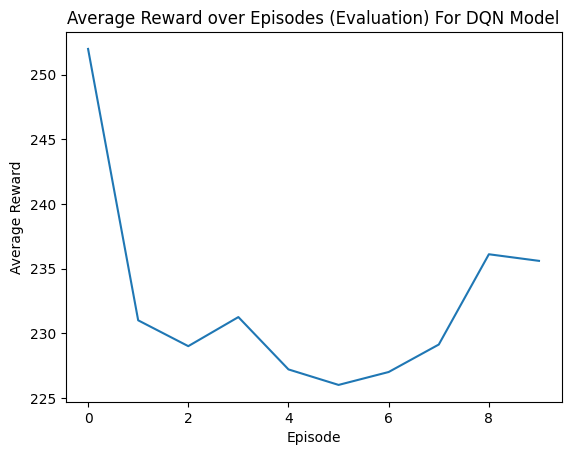

In [ ]:
# Evaluate the policy and store episode rewards
episode_rewards, episode_lengths = evaluate_policy(model_DQN, env, n_eval_episodes=10, return_episode_rewards=True)

# Calculate average reward over episodes
average_rewards = np.cumsum(episode_rewards) / np.arange(1, len(episode_rewards) + 1)

# Plot average reward over episodes
plt.plot(average_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward over Episodes (Evaluation) For DQN Model")
plt.show()
